# Minimum Wage Analysis with MICE

Replicating and enhancing Card and Krueger’s (1994)

[J. Eduardo Vera-Valdés,
<eduardo@math.aau.dk>](mailto:eduardo@math.aau.dk)

## Objective

The aim of this vignette is to replicate and enhance Card and Krueger’s
(1994) analysis of the effect of an increase in the minimum wage on
unemployment by using Multivariate Imputation by Chained Equations
(MICE). Therefore, this vignette will show how to multiply impute Card
and Krueger’s dataset and how to obtain the imputed data for the
econometric analysis. The main objective is to increase your knowledge
and understanding on applications of multiple imputation.

------------------------------------------------------------------------

## The scientific estimand

In this exercise, we are interested in analyzing the effect that an
increase in the minimum wage had on employment.

**Background:** One of the most famous uses of Difference-in-difference
is by Card and Krueger (1994) on the effect of increasing the minimum
wage on unemployment. We are going to replicate some of their results.

**Experiment:** On April 1, 1992, the minimum wage in New Jersey was
raised from \$4.25 to \$5.05. In the neighbouring state of Pennsylvania,
however, the minimum wage remained constant at \$4.25. Card and Krueger
(1994) analyzed the impact of the minimum wage increase on employment in
the fast-food industry, a sector which employs many low-wage workers.

The authors collected data on the number of employees in 331 fast-food
restaurants in New Jersey and 79 in Pennsylvania. The survey was
conducted in February 1992 (before the minimum wage was raised) and in
November 1992 (after the minimum wage was raised).

**Data:** The file *$m\_wage.csv$* (in the folder) includes the
information necessary to replicate Card and Krueger’s analysis. The
dataset is stored in a “wide” format, i.e. there is a single row for
each unit (restaurant), and different columns for the outcomes and
covariates in different years. The dataset includes the following
variables (as well as others which we will not use):

| Variable name | Description                                               |
|---------------|-----------------------------------------------------------|
| $nj$          | dummy equal to 1 if the restaurant is located in NJ       |
| $emptot$      | total number of full-time employed pre-treatment          |
| $emptot2$     | total number of full-time employed post-treatment         |
| $wage\_st$    | average starting wage in the restaurant, pre-treatment    |
| $wage\_st2$   | average starting wage in the restaurant, post-treatment   |
| $pmeal$       | average price of a meal in the pre-treatment period       |
| $pmeal2$      | average price of a meal in the post-treatment period      |
| $co\_owned$   | dummy variable equal to 1 if restaurant was co-owned      |
| $bk$          | dummy variable equal to 1 if restaurant was a Burger King |
| $kfc$         | dummy variable equal to 1 if restaurant was a KFC         |
| $wendys$      | dummy variable equal to 1 if restaurant was Wendys        |

We first load and transform the data to a *long* format with the
following commands.

In [ ]:
## Loading wide data
min_wage <- read.csv("m_wage.csv", header=TRUE, stringsAsFactors=FALSE)

min_wage_feb <- min_wage[,c("nj","wage_st","emptot","kfc", "wendys","co_owned")]
min_wage_nov <- min_wage[,c("nj","wage_st2","emptot2","kfc", "wendys","co_owned")]

## Create a treatment period indicator
min_wage_feb$treatment <- 0
min_wage_nov$treatment <- 1

## Make sure the two data.frames have the same column names
colnames(min_wage_nov) <- colnames(min_wage_feb)

## Stack the data.frames on top of one another
mwl <- rbind(min_wage_feb, min_wage_nov)
rm(min_wage,min_wage_feb,min_wage_nov)

The `mwl` dataset contains 820 observations on 7 variables: *nj*,
*wage_st*, *emptot*, *kfc*, *wendys*, *co_owned*, and *treatment*.

------------------------------------------------------------------------

## Working with mice

------------------------------------------------------------------------

**1. Load the packages `mice` and `lattice`**

In [ ]:
require(mice)
require(lattice)
set.seed(123)

If `mice` is not yet installed, run:

In [ ]:
install.packages("mice")

------------------------------------------------------------------------

**2. Get an overview of the data by the `summary()` command:**

In [ ]:
summary(mwl)

       nj            wage_st          emptot           kfc        
 Min.   :0.0000   Min.   :4.250   Min.   : 0.00   Min.   :0.0000  
 1st Qu.:1.0000   1st Qu.:4.500   1st Qu.:14.50   1st Qu.:0.0000  
 Median :1.0000   Median :5.000   Median :20.00   Median :0.0000  
 Mean   :0.8073   Mean   :4.806   Mean   :21.03   Mean   :0.1951  
 3rd Qu.:1.0000   3rd Qu.:5.050   3rd Qu.:25.50   3rd Qu.:0.0000  
 Max.   :1.0000   Max.   :6.250   Max.   :85.00   Max.   :1.0000  
                  NA's   :41      NA's   :26                      
     wendys          co_owned        treatment  
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0  
 Median :0.0000   Median :0.0000   Median :0.5  
 Mean   :0.1463   Mean   :0.3439   Mean   :0.5  
 3rd Qu.:0.0000   3rd Qu.:1.0000   3rd Qu.:1.0  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0  
                                                

------------------------------------------------------------------------

**3. Inspect the missing data pattern**

Check the missingness pattern for the `mwl` dataset and comment. Use
both `md.pattern` and `md.pairs`.

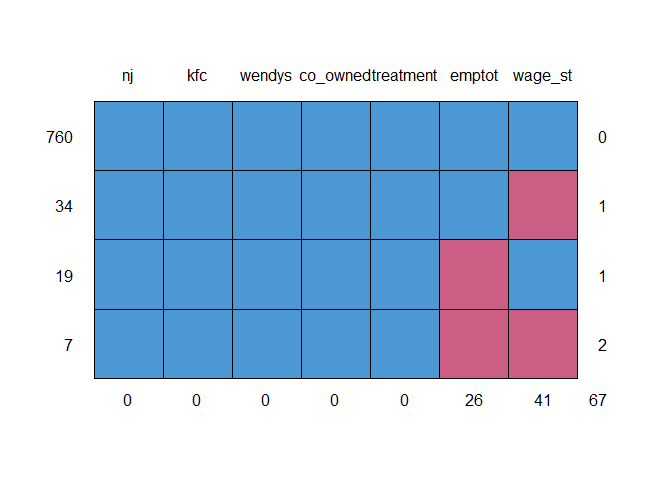

    nj kfc wendys co_owned treatment emptot wage_st   
760  1   1      1        1         1      1       1  0
34   1   1      1        1         1      1       0  1
19   1   1      1        1         1      0       1  1
7    1   1      1        1         1      0       0  2
     0   0      0        0         0     26      41 67

In [ ]:
md.pattern(mwl)

------------------------------------------------------------------------

### Single imputation methods

------------------------------------------------------------------------

**4. Estimate the effect of the increase of minimum wage on employment**

To estimate the effect of the increase in minimum wage on employment we
are interested in fitting the model
$$emptot_{it} = \beta_0 + \beta_1 nj_i + \beta_2 treatment_t + \beta_3 nj_i \times treatment_t + \epsilon_{it}.$$
The effect is then captured by the $\beta_3$ parameter.

Fit the model with the original dataset. You only need to type
*nj\*treatment* in R so that it includes the three regressors
(*nj*,*treatment*,*njXtreatment*), they are called the interaction
terms.

In [ ]:
fit <- with(mwl, lm(emptot ~ nj*treatment))
summary(fit)


Call:
lm(formula = emptot ~ nj * treatment)

Residuals:
    Min      1Q  Median      3Q     Max 
-21.166  -6.439  -1.027   4.473  64.561 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    23.331      1.072  21.767   <2e-16 ***
nj             -2.892      1.194  -2.423   0.0156 *  
treatment      -2.166      1.516  -1.429   0.1535    
nj:treatment    2.754      1.688   1.631   0.1033    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9.406 on 790 degrees of freedom
  (26 observations deleted due to missingness)
Multiple R-squared:  0.007401,  Adjusted R-squared:  0.003632 
F-statistic: 1.964 on 3 and 790 DF,  p-value: 0.118

------------------------------------------------------------------------

**5. Impute the missing data in the `mwl` dataset with mean imputation
and re-estimate the model **

In [ ]:
imp <- mice(mwl, method = "mean", m = 1, maxit = 1)


 iter imp variable
  1   1  wage_st  emptot

# A tibble: 4 × 6
  term         estimate std.error statistic  p.value  nobs
  <chr>           <dbl>     <dbl>     <dbl>    <dbl> <int>
1 (Intercept)     23.3       1.04     22.3  1.09e-86   820
2 nj              -2.82      1.16     -2.43 1.53e- 2   820
3 treatment       -2.11      1.47     -1.43 1.52e- 1   820
4 nj:treatment     2.68      1.64      1.64 1.02e- 1   820

------------------------------------------------------------------------

**6. Impute the missing data with stochastic regression imputation and
re-estimate the model.**

In [ ]:
imp <- mice(mwl, method = "norm.nob", m = 1, maxit = 1)


 iter imp variable
  1   1  wage_st  emptot

# A tibble: 4 × 6
  term         estimate std.error statistic  p.value  nobs
  <chr>           <dbl>     <dbl>     <dbl>    <dbl> <int>
1 (Intercept)     23.0       1.06     21.7  8.85e-83   820
2 nj              -2.56      1.18     -2.17 3.05e- 2   820
3 treatment       -1.82      1.50     -1.22 2.24e- 1   820
4 nj:treatment     2.38      1.67      1.43 1.54e- 1   820

------------------------------------------------------------------------

### Multiple imputation

------------------------------------------------------------------------

**7. Impute the missing data in the `mwl` dataset using default `mice`
options.**

In [ ]:
imp <- mice(mwl,print = FALSE)

------------------------------------------------------------------------

**8. Extract the completed data**

By default, `mice()` calculates five (*m* = 5) imputed data sets. Use
the `complete()` function to get the second imputed data set and examine
it using `md.pattern()`.

 /\     /\
{  `---'  }
{  O   O  }
==>  V <==  No need for mice. This data set is completely observed.
 \  \|/  /
  `-----'

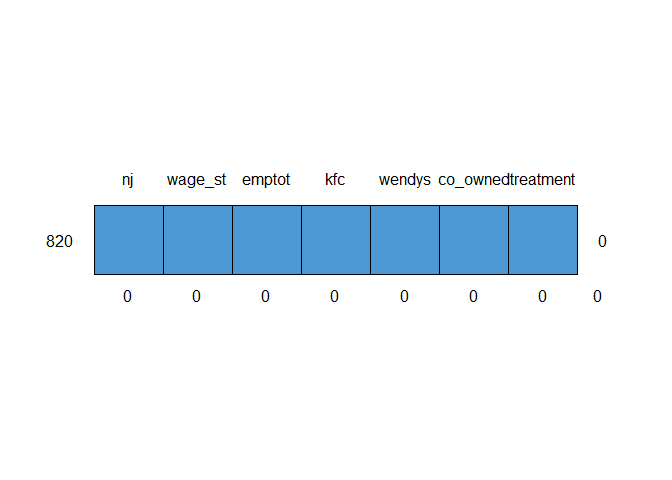

    nj wage_st emptot kfc wendys co_owned treatment  
820  1       1      1   1      1        1         1 0
     0       0      0   0      0        0         0 0

In [ ]:
c2 <- complete(imp, 2) 
md.pattern(c2)

------------------------------------------------------------------------

**9. Vary the number of imputations. **

The number of imputed data sets can be specified by the `m = ...`
argument. Create ten imputed data sets. Use `seed=` for reproducibility.

In [ ]:
imp <- mice(mwl, m = 10, print = FALSE, seed = 123)

------------------------------------------------------------------------

**10. Inspect the convergence of the algorithm**

The `mice()` function implements an iterative Markov Chain Monte Carlo
type of algorithm. Look at the trace lines generated by the algorithm to
study convergence and comment.

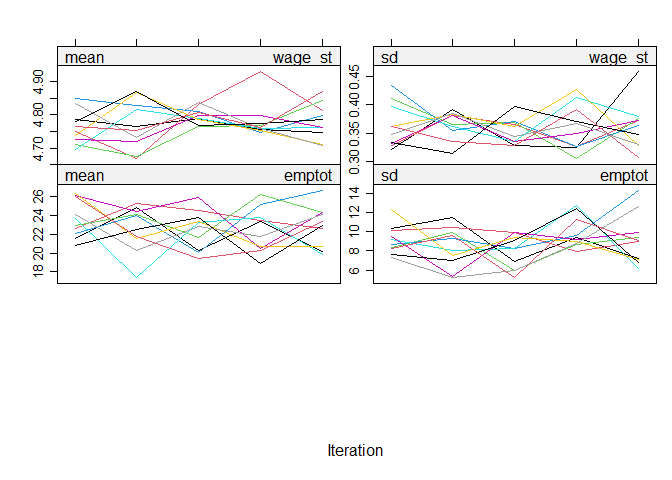

In [ ]:
plot(imp)

------------------------------------------------------------------------

**11. Change the imputation method**

For each column, the algorithm requires a specification of the
imputation method. To see which method was used by default:

In [ ]:
imp$meth

       nj   wage_st    emptot       kfc    wendys  co_owned treatment 
       ""     "pmm"     "pmm"        ""        ""        ""        "" 

Change the imputation method for `emptot` to Bayesian normal linear
regression imputation.

In [ ]:
ini <- mice(mwl, maxit = 0)
meth <- ini$meth
meth

       nj   wage_st    emptot       kfc    wendys  co_owned treatment 
       ""     "pmm"     "pmm"        ""        ""        ""        "" 

       nj   wage_st    emptot       kfc    wendys  co_owned treatment 
       ""     "pmm"    "norm"        ""        ""        ""        "" 

and run the imputations again using the same number of imputations and
seed as before.

In [ ]:
imp <- mice(mwl, meth = meth, m=10, print = FALSE)

Plot the trace lines to study convergence.

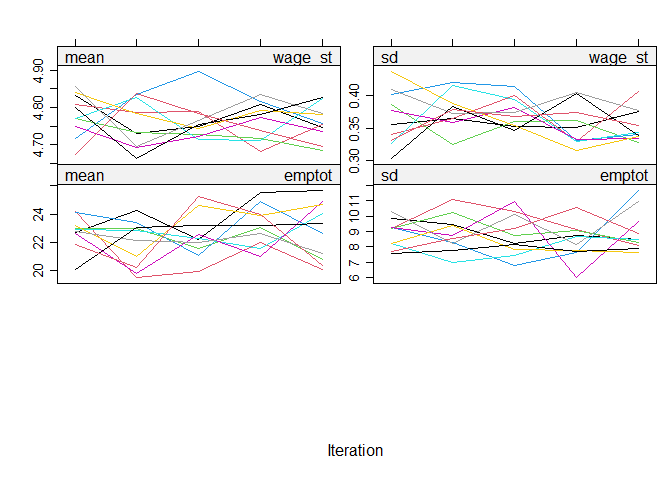

In [ ]:
plot(imp)

------------------------------------------------------------------------

**12. Further diagnostic checking.**

Use function `stripplot()` and comment on the results. Are all
imputations valid?

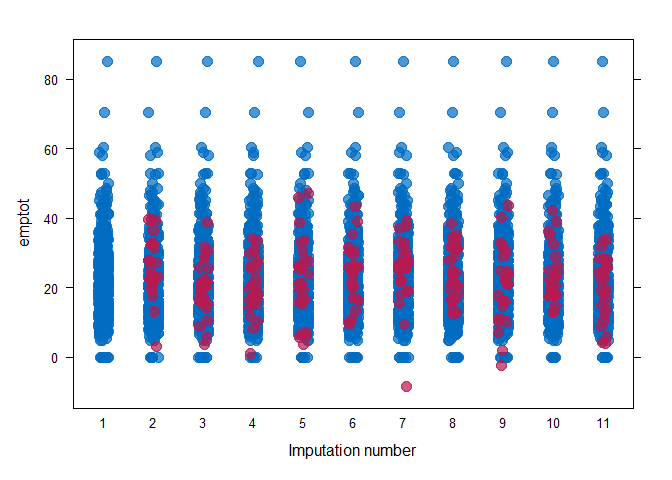

In [ ]:
stripplot(imp, emptot ~ .imp, pch = 20, cex = 2)

**14. Change the imputation method again**

Change the imputation method for `emptot` to CART imputation.

In [ ]:
ini <- mice(mwl, maxit = 0)
meth <- ini$meth
meth["emptot"] <- "cart"
imp <- mice(mwl, meth = meth, m=10, print = FALSE)

Examine the diagnostic plots and comment.

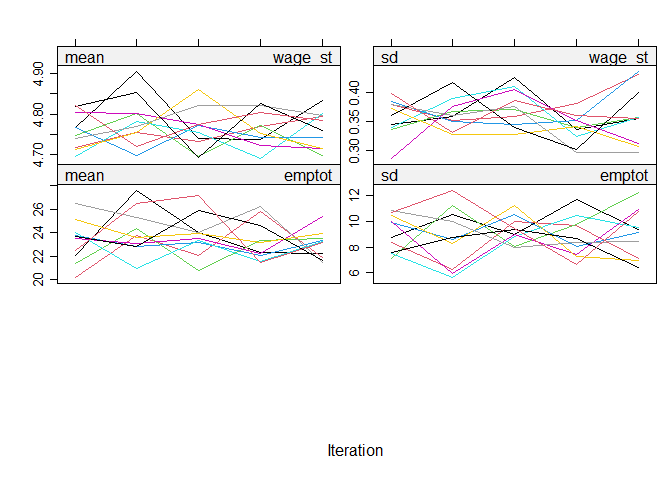

In [ ]:
plot(imp)

Obtain the stripplot and comment.

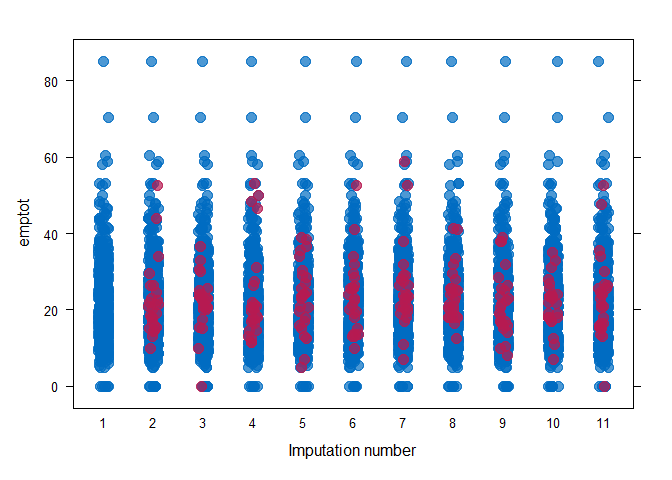

In [ ]:
stripplot(imp, emptot ~ .imp, pch = 20, cex = 2)

------------------------------------------------------------------------

### Repeated analysis in mice

------------------------------------------------------------------------

**15. Perform the regression for the minimum wage effect analysis on the
multiply imputed data. Store the solution in object `fit` and comment on
the estimates. **

In [ ]:
fit <- with(imp, lm(emptot ~ nj*treatment))
fit

call :
with.mids(data = imp, expr = lm(emptot ~ nj * treatment))

call1 :
mice(data = mwl, m = 10, method = meth, printFlag = FALSE)

nmis :
       nj   wage_st    emptot       kfc    wendys  co_owned treatment 
        0        41        26         0         0         0         0 

analyses :
[[1]]

Call:
lm(formula = emptot ~ nj * treatment)

Coefficients:
 (Intercept)            nj     treatment  nj:treatment  
      23.633        -3.235        -2.478         3.177  


[[2]]

Call:
lm(formula = emptot ~ nj * treatment)

Coefficients:
 (Intercept)            nj     treatment  nj:treatment  
      23.348        -2.903        -2.168         2.811  


[[3]]

Call:
lm(formula = emptot ~ nj * treatment)

Coefficients:
 (Intercept)            nj     treatment  nj:treatment  
      23.589        -3.099        -2.446         3.074  


[[4]]

Call:
lm(formula = emptot ~ nj * treatment)

Coefficients:
 (Intercept)            nj     treatment  nj:treatment  
      23.278        -2.776        -1

------------------------------------------------------------------------

**16. Pool the analyses from object `fit` and comment. **

In [ ]:
pool.fit <- pool(fit)
summary(pool.fit)

          term  estimate std.error statistic       df      p.value
1  (Intercept) 23.510443  1.074315 21.884118 726.3353 6.246713e-82
2           nj -3.080307  1.192782 -2.582456 745.9752 9.999436e-03
3    treatment -2.265823  1.516192 -1.494417 743.1543 1.354911e-01
4 nj:treatment  2.967635  1.686012  1.760151 749.8116 7.878986e-02

**17. Squeezing the imputations by Bayesian normal linear regression
imputation**

Use `mice` post-processing to constraint the imputations for *emptot* to
being positive.

In [ ]:
ini <- mice(mwl, maxit = 0)
meth <- ini$meth
meth["emptot"] <- "norm"
imp <- mice(mwl, meth = meth, m=10, print = FALSE)

Squeeze the imputed values to be between 0 and 90.

In [ ]:
post <- ini$post
post["emptot"] <- "imp[[j]][, i] <- squeeze(imp[[j]][, i], c(0, 90))"
imp <- mice(mwl, meth=meth, post=post, print=FALSE)

Obtain the stripplot and comment.

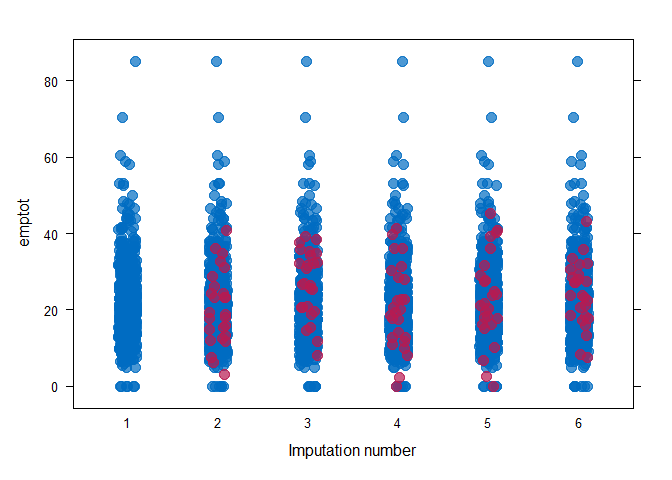

In [ ]:
stripplot(imp, emptot ~ .imp, pch = 20, cex = 2)

**18. Perform the regression for the minimum wage effect analysis on the
multiply imputed data just squeezed. Store the solution in object `fit`
and comment on the estimates. **

In [ ]:
fit <- with(imp, lm(emptot ~ nj*treatment))
fit

call :
with.mids(data = imp, expr = lm(emptot ~ nj * treatment))

call1 :
mice(data = mwl, method = meth, post = post, printFlag = FALSE)

nmis :
       nj   wage_st    emptot       kfc    wendys  co_owned treatment 
        0        41        26         0         0         0         0 

analyses :
[[1]]

Call:
lm(formula = emptot ~ nj * treatment)

Coefficients:
 (Intercept)            nj     treatment  nj:treatment  
      23.352        -2.886        -2.228         2.736  


[[2]]

Call:
lm(formula = emptot ~ nj * treatment)

Coefficients:
 (Intercept)            nj     treatment  nj:treatment  
      23.620        -3.002        -2.433         3.044  


[[3]]

Call:
lm(formula = emptot ~ nj * treatment)

Coefficients:
 (Intercept)            nj     treatment  nj:treatment  
      23.387        -2.993        -1.915         2.474  


[[4]]

Call:
lm(formula = emptot ~ nj * treatment)

Coefficients:
 (Intercept)            nj     treatment  nj:treatment  
      23.339        -2.715     

------------------------------------------------------------------------

**19. Pool the analyses from object `fit` and comment. **

In [ ]:
pool.fit <- pool(fit)
summary(pool.fit)

          term  estimate std.error statistic       df      p.value
1  (Intercept) 23.427573  1.068216 21.931488 773.3781 2.801035e-83
2           nj -2.913516  1.187961 -2.452534 780.5114 1.440327e-02
3    treatment -2.181681  1.518957 -1.436302 709.6616 1.513570e-01
4 nj:treatment  2.733824  1.710117  1.598618 545.3218 1.104847e-01

**20. Binary missing data.**

`Generate` 25 missing data in the *co_owned* variable using the
`sample()` function and random seed as before. Call the new dataset
*nmwl* making sure to define the *co_owned* variable as categorical
using the `as.factor()`.

In [ ]:
set.seed(123)
miss_ind = sample(820,25)
nmwl= mwl
nmwl$co_owned[miss_ind] = NA
nmwl$co_owned = as.factor(nmwl$co_owned)

**21. Examine the pattern of missing data**

Obtain the missing data pattern and comment.

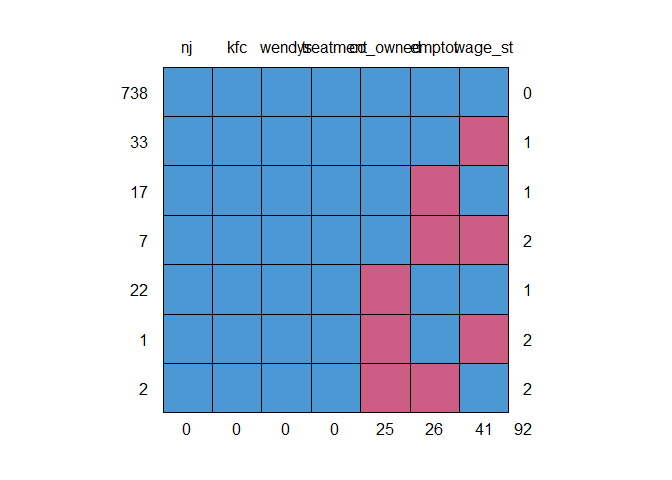

    nj kfc wendys treatment co_owned emptot wage_st   
738  1   1      1         1        1      1       1  0
33   1   1      1         1        1      1       0  1
17   1   1      1         1        1      0       1  1
7    1   1      1         1        1      0       0  2
22   1   1      1         1        0      1       1  1
1    1   1      1         1        0      1       0  2
2    1   1      1         1        0      0       1  2
     0   0      0         0       25     26      41 92

In [ ]:
md.pattern(nmwl)

In [ ]:
md.pairs(nmwl)

$rr
           nj wage_st emptot kfc wendys co_owned treatment
nj        820     779    794 820    820      795       820
wage_st   779     779    760 779    779      755       779
emptot    794     760    794 794    794      771       794
kfc       820     779    794 820    820      795       820
wendys    820     779    794 820    820      795       820
co_owned  795     755    771 795    795      795       795
treatment 820     779    794 820    820      795       820

$rm
          nj wage_st emptot kfc wendys co_owned treatment
nj         0      41     26   0      0       25         0
wage_st    0       0     19   0      0       24         0
emptot     0      34      0   0      0       23         0
kfc        0      41     26   0      0       25         0
wendys     0      41     26   0      0       25         0
co_owned   0      40     24   0      0        0         0
treatment  0      41     26   0      0       25         0

$mr
          nj wage_st emptot kfc wendys co_owned tr

**21. Impute the missing data and examine the method selected for the
binary variable**

In [ ]:
ini <- mice(nmwl, maxit = 0)
meth <- ini$meth
meth

       nj   wage_st    emptot       kfc    wendys  co_owned treatment 
       ""     "pmm"     "pmm"        ""        ""  "logreg"        "" 

**22. Change the imputation method one last time**

Change the imputation method for `emptot` to linear regression with
bootstrap and logistic regression with bootstrap for `co_owned`.

In [ ]:
ini <- mice(nmwl, maxit = 0)
meth <- ini$meth
meth["emptot"] <- "norm.boot"
meth["co_owned"] <- "logreg.boot"
imp <- mice(nmwl, meth = meth, m=10, print = FALSE)

Diagnostic checks.

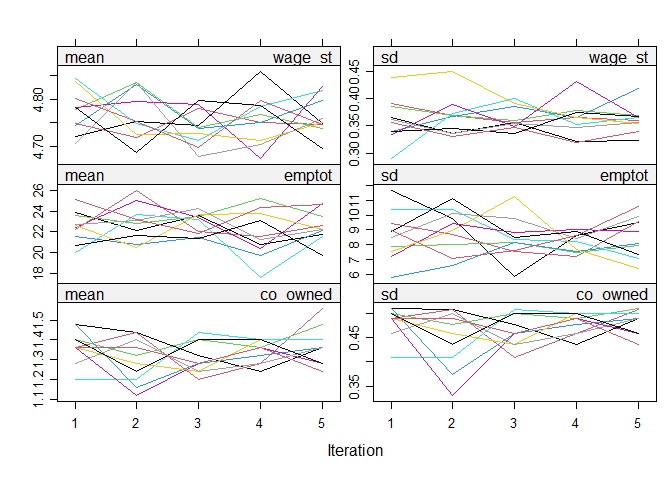

In [ ]:
plot(imp)

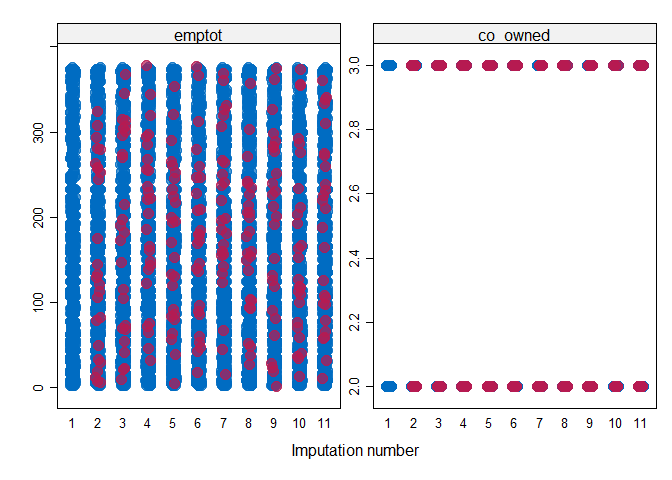

In [ ]:
stripplot(imp, emptot + co_owned ~ .imp, pch = 20, cex = 2)

Compare the predictions to the true values for *co_owned*.

In [ ]:
cbind(mwl$co_owned[miss_ind],imp$imp$co_owned[])

    mwl$co_owned[miss_ind] 1 2 3 4 5 6 7 8 9 10
14                       1 0 1 1 0 1 0 0 0 1  1
26                       0 1 1 1 0 0 0 0 1 1  0
91                       0 1 1 1 1 0 0 0 1 0  0
118                      0 0 1 1 1 0 0 0 0 0  0
179                      0 0 0 1 0 1 0 0 0 0  1
195                      0 0 0 0 0 0 1 0 0 0  0
229                      0 0 0 1 1 0 0 1 0 0  0
244                      0 1 1 0 0 0 1 1 1 0  0
299                      1 0 1 1 0 1 0 0 0 0  0
348                      0 0 0 0 0 1 0 0 1 0  0
355                      0 1 1 1 1 1 0 1 1 1  0
374                      0 0 0 0 0 0 0 0 0 0  0
415                      0 0 0 0 0 1 0 1 0 0  0
426                      1 1 1 1 1 0 0 0 0 0  1
463                      1 0 1 0 0 1 1 0 1 1  0
519                      0 0 1 0 0 0 0 0 0 0  0
526                      0 1 0 0 1 1 1 0 1 0  1
602                      0 0 1 1 1 1 0 1 0 0  1
603                      1 1 1 0 0 0 0 1 0 1  0
649                      1 0 0 0 0 0 1 0

Squeeze the imputed values for *emptot* to be between 0 and 90.

In [ ]:
post <- ini$post
post["emptot"] <- "imp[[j]][, i] <- squeeze(imp[[j]][, i], c(0, 90))"
imp <- mice(nmwl, meth=meth, post=post, print=FALSE)

**23. Perform the regression for the minimum wage effect analysis one
last time**

Consider the linear regression in the last imputed dataset in the the
extended specification controlling for whether the restaurant was
co-owned, a Burger King, a KFC, or a Wendys. The specification is

Do your estimates of the treatment effect differ? Are they statistically
significant?

In [ ]:
fit <- with(imp, lm(emptot ~ nj*treatment+co_owned+kfc+wendys))
fit

call :
with.mids(data = imp, expr = lm(emptot ~ nj * treatment + co_owned + 
    kfc + wendys))

call1 :
mice(data = nmwl, method = meth, post = post, printFlag = FALSE)

nmis :
       nj   wage_st    emptot       kfc    wendys  co_owned treatment 
        0        41        26         0         0        25         0 

analyses :
[[1]]

Call:
lm(formula = emptot ~ nj * treatment + co_owned + kfc + wendys)

Coefficients:
 (Intercept)            nj     treatment     co_owned1           kfc  
     25.5221       -2.3767       -2.0957       -1.7305       -9.8914  
      wendys  nj:treatment  
     -0.2719        2.7588  


[[2]]

Call:
lm(formula = emptot ~ nj * treatment + co_owned + kfc + wendys)

Coefficients:
 (Intercept)            nj     treatment     co_owned1           kfc  
     25.7746       -2.3291       -2.3911       -2.0702       -9.8701  
      wendys  nj:treatment  
     -0.3066        2.9189  


[[3]]

Call:
lm(formula = emptot ~ nj * treatment + co_owned + kfc + wendys)

Co

In [ ]:
pool.fit <- pool(fit)
summary(pool.fit)

          term   estimate std.error   statistic       df      p.value
1  (Intercept) 25.6881482 1.0227476  25.1168024 692.9852 1.732774e-99
2           nj -2.4591805 1.0762578  -2.2849363 758.3143 2.259189e-02
3    treatment -2.3332544 1.3744657  -1.6975720 677.6548 9.004771e-02
4    co_owned1 -1.8840372 0.6591614  -2.8582333 356.8792 4.510091e-03
5          kfc -9.8394792 0.7717286 -12.7499213 802.1252 4.910345e-34
6       wendys -0.5414838 0.9248559  -0.5854791 186.9380 5.589317e-01
7 nj:treatment  2.9446525 1.5216956   1.9351128 745.3697 5.335444e-02

------------------------------------------------------------------------

## References

Card, David and Krueger, Alan B. (1994). *Minimum Wages and Employment:
A Case Study of the Fast-Food Industry in New Jersey and Pennsylvania.*
**American Economic Review**, 84(4), pp.772-93.